In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
parisrohan_credit_score_classification_path = kagglehub.dataset_download('parisrohan/credit-score-classification')

print('Data source import complete.')


Data source import complete.


In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer



In [9]:
# Step 1: Load Dataset
df = pd.read_csv("/kaggle/input/credit-score-classification/train.csv")


<ipython-input-9-2b282cc9410f>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/credit-score-classification/train.csv")


In [10]:
df.shape

(100000, 28)

In [11]:
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [12]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=bcd7aa3554d261e84caf9bea9b3c6765050eb5d774be8e70f905ded2446da07f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [13]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00


In [14]:
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [15]:
df = df.drop(columns=[
    'ID', 'Customer_ID', 'Name', 'SSN'
])

le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

one_hot_cols = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2, 'Excellent': 3}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_map)

target_encoder = ce.TargetEncoder()
df['Type_of_Loan'] = target_encoder.fit_transform(df['Type_of_Loan'], df['Credit_Score'])


df = df.fillna(df.mean(numeric_only=True))

def convert_credit_age(val):
    try:
        years = int(val.split(" ")[0])
        months = int(val.split(" ")[3])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)

In [16]:
object_cols = df.select_dtypes(include='object').columns
print(object_cols)
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


Index(['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')


In [17]:
# Step 3: Feature Selection - Chi-Square
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

In [18]:
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

y.fillna(y.mode()[0], inplace=True)

<ipython-input-18-8c83a6e02682>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
<ipython-input-18-8c83a6e02682>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [19]:



# selector = SelectKBest(chi2, k=15)  # Select top 15 features
# X_selected = selector.fit_transform(X, y)
# selected_features = X.columns[selector.get_support(indices=True)]

# print("Selected features:", selected_features.tolist())


In [20]:

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)


In [21]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
parisrohan_credit_score_classification_path = kagglehub.dataset_download('parisrohan/credit-score-classification')

print('Data source import complete.')


Data source import complete.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [23]:
df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


<ipython-input-23-08e27cc410b0>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')


In [24]:

print("\nDataset Info:")
df.info()




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              8859

In [25]:
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [26]:

df.isnull().sum()


,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [27]:
df.duplicated().sum()


np.int64(0)

In [28]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


ID: 100000 unique values
Customer_ID: 12500 unique values
Month: 8 unique values
Name: 10139 unique values
Age: 1788 unique values
SSN: 12501 unique values
Occupation: 16 unique values
Annual_Income: 18940 unique values
Num_of_Loan: 434 unique values
Type_of_Loan: 6260 unique values
Num_of_Delayed_Payment: 749 unique values
Changed_Credit_Limit: 4384 unique values
Credit_Mix: 4 unique values
Outstanding_Debt: 13178 unique values
Credit_History_Age: 404 unique values
Payment_of_Min_Amount: 3 unique values
Amount_invested_monthly: 91049 unique values
Payment_Behaviour: 7 unique values
Monthly_Balance: 98792 unique values
Credit_Score: 3 unique values


In [29]:
df = df.drop(columns=[
    'ID', 'Customer_ID', 'Name', 'SSN'
])

le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

one_hot_cols = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2, 'Excellent': 3}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_map)

target_encoder = ce.TargetEncoder()
df['Type_of_Loan'] = target_encoder.fit_transform(df['Type_of_Loan'], df['Credit_Score'])


df = df.fillna(df.mean(numeric_only=True))

def convert_credit_age(val):
    try:
        years = int(val.split(" ")[0])
        months = int(val.split(" ")[3])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)

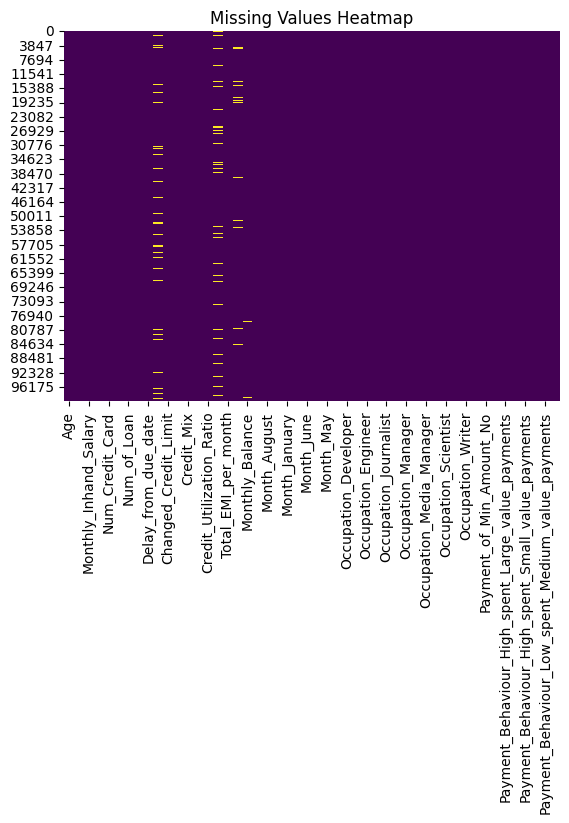

In [30]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


In [31]:
print(df.dtypes)

Age                                                    object
Annual_Income                                          object
Monthly_Inhand_Salary                                 float64
Num_Bank_Accounts                                       int64
Num_Credit_Card                                         int64
Interest_Rate                                           int64
Num_of_Loan                                            object
Type_of_Loan                                          float64
Delay_from_due_date                                     int64
Num_of_Delayed_Payment                                 object
Changed_Credit_Limit                                   object
Num_Credit_Inquiries                                  float64
Credit_Mix                                            float64
Outstanding_Debt                                       object
Credit_Utilization_Ratio                              float64
Credit_History_Age                                    float64
Total_EM

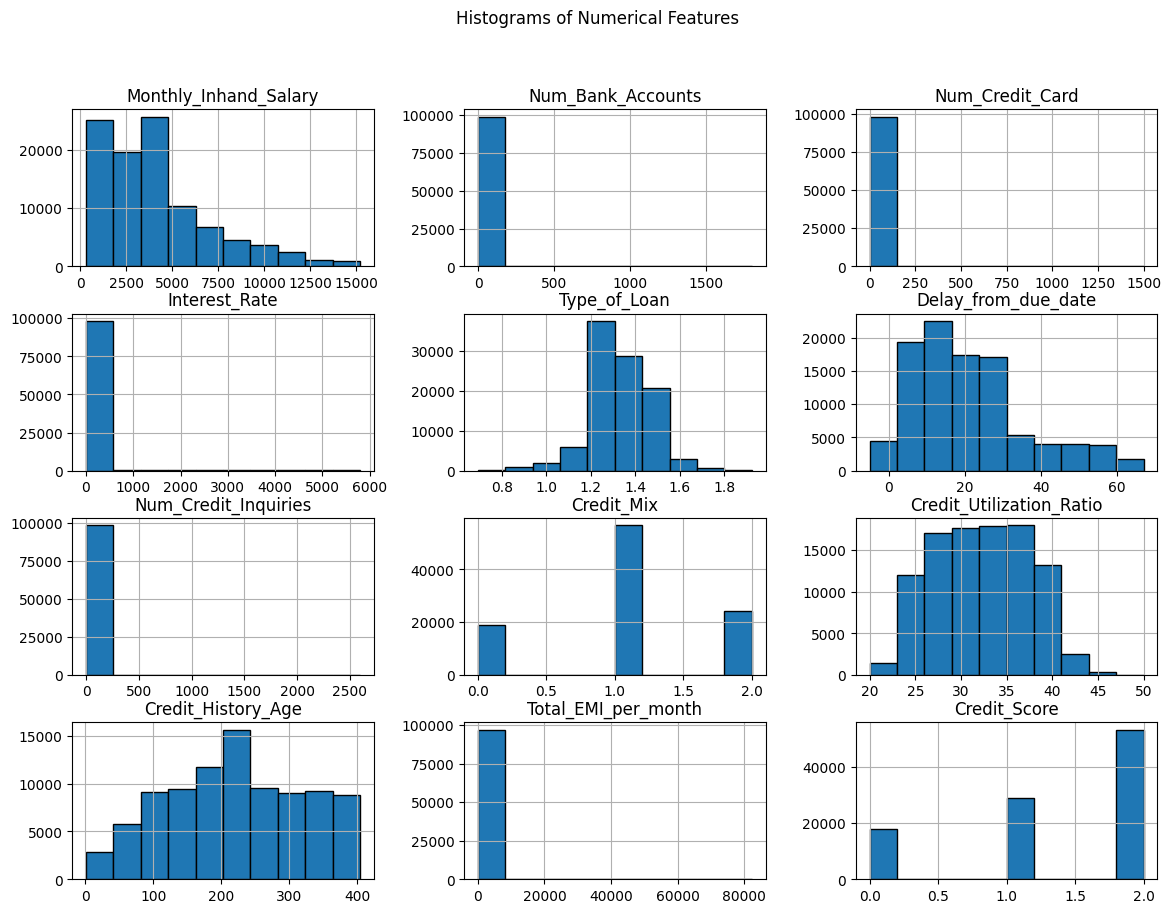

In [32]:

df.hist(figsize=(14,10), edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()





In [33]:
categorical_features = df.select_dtypes(include='object').columns
for col in categorical_features:
    print(f"\nValue Counts for {col}:\n", df[col].value_counts(normalize=True))


Value Counts for Age:
 Age
38      0.02833
28      0.02829
31      0.02806
26      0.02792
32      0.02749
         ...   
6618    0.00001
3155    0.00001
5063    0.00001
2875    0.00001
4347    0.00001
Name: proportion, Length: 1788, dtype: float64

Value Counts for Annual_Income:
 Annual_Income
36585.12     0.00016
20867.67     0.00016
17273.83     0.00016
95596.35     0.00015
33029.66     0.00015
              ...   
3917169.0    0.00001
89394.78_    0.00001
36806.84_    0.00001
24363.78_    0.00001
95685.21_    0.00001
Name: proportion, Length: 18940, dtype: float64

Value Counts for Num_of_Loan:
 Num_of_Loan
3      0.14386
2      0.14250
4      0.14016
0      0.10380
1      0.10083
        ...   
41     0.00001
18     0.00001
56     0.00001
657    0.00001
917    0.00001
Name: proportion, Length: 434, dtype: float64

Value Counts for Num_of_Delayed_Payment:
 Num_of_Delayed_Payment
19      0.057281
17      0.056571
16      0.055625
10      0.055410
18      0.054657
          ...   

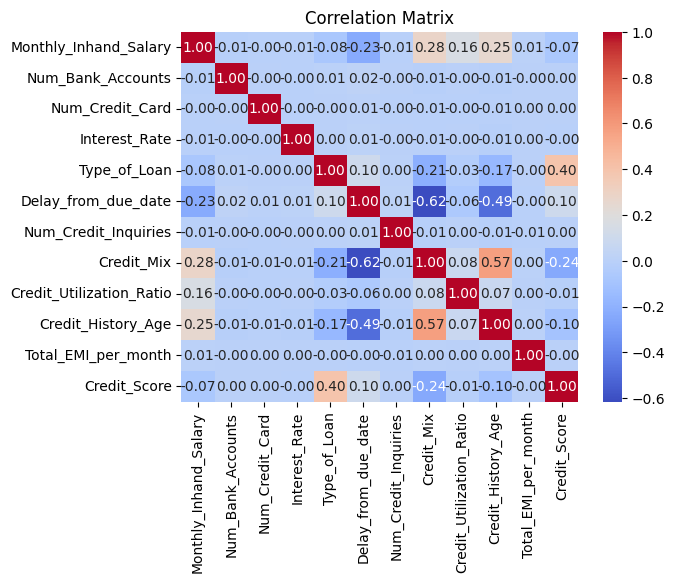

In [34]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
corr = df[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



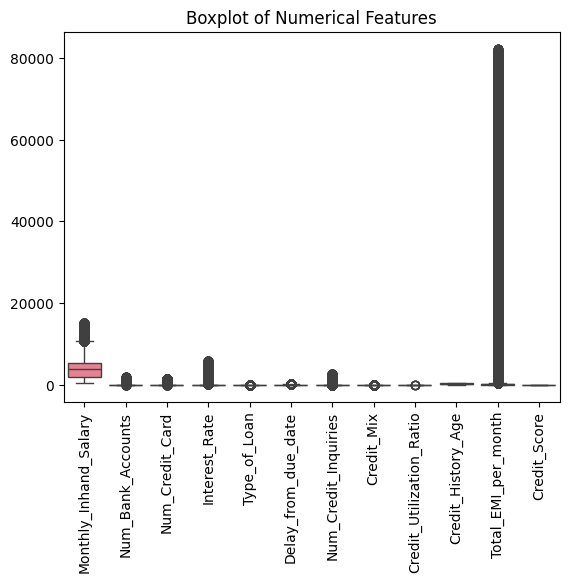

In [35]:
sns.boxplot(data=df[numerical_features])
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=90)
plt.show()



In [36]:
object_cols = df.select_dtypes(include='object').columns
print(object_cols)
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


Index(['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')


In [37]:
X = df.drop(columns='Credit_Score')
y = df['Credit_Score']
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

y.fillna(y.mode()[0], inplace=True)


<ipython-input-37-7282809c8af6>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
<ipython-input-37-7282809c8af6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [38]:
X.isnull().sum()


,0
Age,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0
Num_Credit_Card,0
Interest_Rate,0
Num_of_Loan,0
Type_of_Loan,0
Delay_from_due_date,0
Num_of_Delayed_Payment,0


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [40]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import shap, lime.lime_tabular, matplotlib.pyplot as plt
import numpy as np

start_time_nb = time.time()


svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
training_time_nb = time.time() - start_time_nb


In [41]:


from sklearn.metrics import accuracy_score, confusion_matrix

def evaluate_model(model, X_test, y_test, training_time):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average='macro')

    cm = confusion_matrix(y_test, y_pred)

    if cm.shape == (2, 2):
        fp = cm[0][1] / (cm[0][0] + cm[0][1])
        fn = cm[1][0] / (cm[1][0] + cm[1][1])
    else:
        fp = fn = "N/A (multiclass)"

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"False Positive Rate (FPR): {fp}")
    print(f"False Negative Rate (FNR): {fn}")
    print(f"Training Time: {training_time:.4f} seconds")


evaluate_model(svm, X_test, y_test, training_time_nb)


Accuracy: 0.5300
F1 Score (macro): 0.2309
False Positive Rate (FPR): N/A (multiclass)
False Negative Rate (FNR): N/A (multiclass)
Training Time: 4909.1834 seconds


In [ ]:
# import shap

# background = shap.kmeans(X_train, 100)

# explainer_svm = shap.KernelExplainer(svm.predict_proba, background)

# shap_values_svm = explainer_svm.shap_values(X_test.iloc[:200])

# shap.summary_plot(shap_values_svm, X_test.iloc[:200], feature_names=X_train.columns)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, class_names=np.unique(y_train).astype(str), mode='classification')
exp = explainer_lime.explain_instance(X_test.iloc[0], svm.predict_proba)
exp.show_in_notebook(show_table=True)

In [ ]:
odds_ratios = np.exp(svm.coef_[0])
print("Odds Ratios:")
for feat, odds in zip(X_train.columns, odds_ratios):
    print(f"{feat}: {odds:.2f}")

In [ ]:
ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.show()